In [1]:
from __future__ import print_function

__docformat__ = 'restructedtext en'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import _pickle as cPickle
import gzip
import os
import sys
import timeit
from sklearn.metrics import confusion_matrix
import math
import os

In [3]:
# Import Theano
# Calculate the time it takes to import Theano
start_time = timeit.default_timer()
import theano
end_time = timeit.default_timer()
print("It took Theano %.1fs to load." % (end_time - start_time))

It took Theano 2.5s to load.


Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 860M (0000:01:00.0)


In [4]:
import theano.tensor as T

In [5]:
# import LogisticRegression and load_mnist_data functions from mnist_logistic_regression.py

from load_mnist_dataset import load_mnist_data
dataset = '/home/dashsid/MNIST/mnist.pkl.gz'

# load the dataset
datasets = load_mnist_data(dataset)
    
# retrieve the correct dataset partitions
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

/home/dashsid/MNIST
mnist.pkl.gz
Loading MNIST data...


In [6]:
# Print the no of training, validation, and test data

# Print the type of the shared variable for the dataset
print(train_set_x)

print(train_set_x.get_value())
print(valid_set_x.get_value())
print(test_set_x.get_value())

print("Size of the training dataset: ", train_set_x.get_value().shape)
print("Size of the validation dataset: ", valid_set_x.get_value().shape)
print("Size of the test dataset: ", test_set_x.get_value().shape)

<GpuArrayType<None>(float32, (False, False))>
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Size of the training dataset:  (50000, 784)
Size of the validation dataset:  (10000, 784)
Size of the test dataset:  (10000, 784)


## Define Network and Data Parameters

In [7]:
# Data dimensions

# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
n_input = img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10
n_output = num_classes

In [8]:
# Training Parameters
learning_rate = 0.01
batch_size = 256

## Visualize the Data from the Actual Dataset

In [9]:
from utils import tile_raster_images

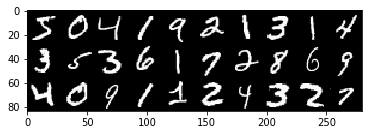

In [10]:
samples = tile_raster_images(train_set_x.get_value(), img_shape=img_shape, 
                             tile_shape=(3, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [11]:
# Print the labels from the dataset
print(train_set_y)

print(train_set_y[:10].eval())

Elemwise{Cast{int32}}.0
[5 0 4 1 9 2 1 3 1 4]


## Data Normalization - PreProcessing

In [12]:
# Apply mean and standard deviation to normalize the data
norm_mean = train_set_x.mean(axis=0)
norm_std =  train_set_x.std(axis=0)
norm_std = norm_std.clip(0.00001, norm_std.max())

# Normalize the training data
train_set_x = train_set_x - norm_mean
train_set_x = train_set_x / norm_std

# Normalize the test data
test_set_x = test_set_x - norm_mean
test_set_x = test_set_x / norm_std

# Normalize the validation data
valid_set_x = valid_set_x - norm_mean
valid_set_x = valid_set_x / norm_std

### Visualize the Pre-Processed Data

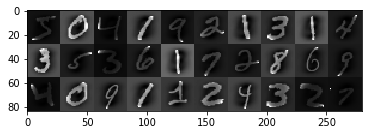

In [13]:
samples = tile_raster_images(train_set_x.eval(), img_shape=(img_size, img_size), 
                             tile_shape=(3, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [14]:
print("Before creating shared variables...")
print(train_set_x)

train_set_x = theano.shared(train_set_x.eval())
valid_set_x = theano.shared(valid_set_x.eval())
test_set_x = theano.shared(test_set_x.eval())

print("After creating shared variables...")
print(train_set_x)
print(valid_set_x)
print(test_set_x)

Before creating shared variables...
Elemwise{true_div,no_inplace}.0
After creating shared variables...
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>


## Create Logistic Regression Model

In [15]:
# Create a Multi-class Logistic Regression Class

class LogisticRegression(object):
    
    # Initialize the parameters
    def __init__(self, input, n_in, n_out):
        
        # model input
        self.input = input
    
        # initialize weights
        self.W = theano.shared(value=np.zeros((n_in, n_out), dtype=theano.config.floatX), name='W', borrow=True)

        # intialize biases
        self.b = theano.shared(value=np.zeros((n_out,), dtype=theano.config.floatX), name='b', borrow=True)

        # parameters of the model
        self.params = [self.W, self.b]

        # implement the model using softmax activation function
        # x represents input training sample
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # calculate the prediction of the output which has maximum probability
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)        
    
    # Compute the cost
    # Find the mean of the negative log-likelihood cost value of predictions
    def negative_log_likelihood(self, y):
        cost = -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        return cost
    
    
    # Find the number of errors in the minibatch over the total number of examples in the minibatch
    def errors(self, y):
        
        # check if y has the same dimension of y_pred vector
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred', 'y', y.type, 'y_pred', self.y_pred.type)

        # check if y is of the correct datatype (integer)
        if y.dtype.startswith('int'):
            error = T.mean(T.neq(self.y_pred, y))
            return error
        else:
            raise NotImplementedError()
            
    # Define Accuracy
    def accuracy(self, y):
        correct_prediction = T.eq(self.y_pred, y)
        accuracy = T.mean(T.cast(correct_prediction, dtype=theano.config.floatX))
        return accuracy

## Declare Placeholders for Theano Shared Variables

In [16]:
# Create symbolic variables for input data, x represents rasterized images, y represents labels
x = T.fmatrix('x')
y = T.ivector('y')

In [17]:
# create a symbolic variable for the index to a minibatch
# T.lscalar() is int64
# index = T.lscalar()

# T.iscalar is int32
index = T.lscalar('batch_index')
print('Index Type: ', index.type)

# batch_size = T.scalar('batch size', dtype='int32')
# batch_size = T.iscalar('batch_size')
# print('Batch Size Type: ', batch_size.type)

Index Type:  TensorType(int64, scalar)


In [18]:
# compute no of minibatches for training, validation and testing
# // operator is used for integer floor division
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

# n_train_batches = train_set_x.shape[0].eval() // batch_size
print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 195
# of Validation batches 39
# of Test batches 39


## Theano Functions with Shared Variable Input

In [19]:
trainx = train_set_x.eval()
trainy = train_set_y.eval()

validx = valid_set_x.eval()
validy = valid_set_y.eval()

testx = test_set_x.eval()
testy = test_set_y.eval()

## Build the Logistic Regression Model Classifier

In [20]:
# build the model
print("Building the logistic regression model.....")

# construct the MLP model
classifier = LogisticRegression(input=x, n_in=n_input, n_out=n_output)

# find the cost without L1/L2 regularization
cost = classifier.negative_log_likelihood(y)
    
# find the cost with L1/L2 regularization
# cost = (classifier.negative_log_likelihood(y) + L1_reg * classifier.L1 + L2_reg * classifier.L2_sqr)
    
# Compute the gradients of weights and biases w.r.t theta = (W, b)
g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)
    
# Update the parameters at each learning step for optimization
updates = [(classifier.W, classifier.W - learning_rate * g_W), 
           (classifier.b, classifier.b - learning_rate * g_b)]

# compute the errors
errors = classifier.errors(y)

# compute the accuracy
accuracy = classifier.accuracy(y)

Building the logistic regression model.....


## Build the Model for Training, Validation, and Test Sets

In [21]:
# compile the Theano function for the test model
test_model = theano.function([index], 
                             errors, 
                             givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                     y: test_set_y[index * batch_size: (index + 1) * batch_size]})
    
    
# Theano function for test model accuracy
test_model_accuracy = theano.function(inputs=[index], 
                                      outputs=accuracy, 
                                      givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                              y: test_set_y[index * batch_size: (index + 1) * batch_size]})
    
    
# compile the Theano function for the validation model
validate_model = theano.function([index], 
                                 errors, 
                                 givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                         y: valid_set_y[index * batch_size: (index + 1) * batch_size]})
    

# Theano function for validation model accuracy
valid_model_accuracy = theano.function(inputs=[index], 
                                       outputs=accuracy, 
                                       givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                               y: valid_set_y[index * batch_size: (index + 1) * batch_size]})
    

# compile the Theano function for the train model
train_model = theano.function([index], 
                              cost, 
                              updates=updates, 
                              givens={x: train_set_x[index * batch_size: (index + 1) * batch_size], 
                                      y: train_set_y[index * batch_size: (index + 1) * batch_size]})


# Theano function for the train model accuracy
train_model_accuracy = theano.function(inputs=[index], 
                                       outputs=accuracy, 
                                       updates=updates, 
                                       givens={x: train_set_x[index * batch_size: (index + 1) * batch_size], 
                                               y: train_set_y[index * batch_size: (index + 1) * batch_size]})

## Perform the Training

## Helper Function to Perform Optimization - Stochastic Gradient Descent Optimization

In [22]:
def sgd_optimization_mnist(dataset, learning_rate, n_epochs, batch_size):
    
    # ---------------
    # Train the model
    # ---------------
    print("Training the Logistic Regression model...")
    
    
    # keep track of the validation loss and the test scores
    start_time = timeit.default_timer()
    
    # ----------------------------------------------------------
    # Begin the training loop
    # The outer while loop loops over the no of iterations (epochs)
    # The inner loop loops over the minibatches
    finished = False
    curr_epoch = 0
    
    while (curr_epoch < n_epochs) and (not finished):
        
        curr_epoch += 1
        
        for minibatch_i in range(n_train_batches):
            
            # calculate the average likelihood(cost) for the minibatches
            minibatch_avg_cost = train_model(minibatch_i)
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            # perform iterations on validation set
            if ((iter + 1) % n_train_batches == 0):
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)
                
                # evaluate the train loss on the training batches
                train_loss= [train_model(i) for i in range(n_train_batches)]

                train_accuracy = [train_model_accuracy(i) for i in range(n_train_batches)]

                # find the average train loss for each training batch
                train_avg_loss = np.mean(train_loss)

                train_avg_accuracy = np.mean(train_accuracy)
                
                
                # evaluate the validation loss on the validation batches
                valid_loss = [validate_model(i) for i in range(n_valid_batches)]

                valid_accuracy = [valid_model_accuracy(i) for i in range(n_valid_batches)]

                # find the average validation loss for each batch
                valid_avg_loss = np.mean(valid_loss)

                valid_avg_accuracy = np.mean(valid_accuracy)
                
                
                # evaluate the test loss on the test batches
                test_loss = [test_model(i) for i in range(n_test_batches)]

                test_accuracy = [test_model_accuracy(i) for i in range(n_test_batches)]

                # find the average test loss for each batch
                test_avg_loss = np.mean(test_loss)

                test_avg_accuracy = np.mean(test_accuracy)
                
                
                msg = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
                print(msg.format(train_avg_accuracy, valid_avg_accuracy))

                msg1 = ("Training Cost %f %%, Validation Loss %f %%") % (train_avg_loss * 100., valid_avg_loss * 100.)
                print(msg1)
                    
                # serialize the model to disk using pickle
                with open('best_mnist_linear_model.pkl', 'wb') as f:
                    cPickle.dump(classifier, f)
                    
                print("=====================================================================")
                print("=====================================================================")
                
    end_time = timeit.default_timer()
    
    time_diff = end_time - start_time
    
    train_perf_score = train_avg_loss * 100.
    valid_perf_score = valid_avg_loss * 100.
    test_perf_score = test_avg_loss * 100.
    
    train_best_accuracy = train_avg_accuracy * 100.
    valid_best_accuracy = valid_avg_accuracy * 100.
    test_best_accuracy = test_avg_accuracy * 100.
    
    print(("Optimization completed with training performance score of %f %%, validation peformance score of %f %%, \
           and test performance score of %f %%") % (train_perf_score, valid_perf_score, test_perf_score))
    
    print(("Training Accuracy %f %%, Validation Accuracy %f %%, and Test Accuracy %f %%") % 
          (train_best_accuracy, valid_best_accuracy, test_best_accuracy))
    
    print("The code ran for %d epochs, with %f epochs/sec" % (curr_epoch, 1. * curr_epoch / time_diff))
    print("The code ran for %.1fs" % time_diff)
    
    print("The code ran for %.2fm" % (time_diff / 60.))

In [23]:
sgd_optimization_mnist(dataset=dataset, learning_rate=learning_rate, n_epochs=100, batch_size=batch_size)

Training the Logistic Regression model...
Epoch 1, Minibatch 195/195 
Training Accuracy:  89.0%, Validation Accuracy:  90.4%
Training Cost 47.046921 %, Validation Loss 9.625401 %
Epoch 2, Minibatch 195/195 
Training Accuracy:  90.3%, Validation Accuracy:  91.2%
Training Cost 36.075103 %, Validation Loss 8.794071 %
Epoch 3, Minibatch 195/195 
Training Accuracy:  90.9%, Validation Accuracy:  91.6%
Training Cost 33.013716 %, Validation Loss 8.383413 %
Epoch 4, Minibatch 195/195 
Training Accuracy:  91.3%, Validation Accuracy:  91.9%
Training Cost 31.407854 %, Validation Loss 8.112981 %
Epoch 5, Minibatch 195/195 
Training Accuracy:  91.5%, Validation Accuracy:  92.1%
Training Cost 30.374616 %, Validation Loss 7.912660 %
Epoch 6, Minibatch 195/195 
Training Accuracy:  91.7%, Validation Accuracy:  92.2%
Training Cost 29.635257 %, Validation Loss 7.832532 %
Epoch 7, Minibatch 195/195 
Training Accuracy:  91.9%, Validation Accuracy:  92.2%
Training Cost 29.069936 %, Validation Loss 7.782452 %

Training Accuracy:  93.1%, Validation Accuracy:  92.7%
Training Cost 25.169149 %, Validation Loss 7.301683 %
Epoch 32, Minibatch 195/195 
Training Accuracy:  93.1%, Validation Accuracy:  92.7%
Training Cost 25.103039 %, Validation Loss 7.321715 %
Epoch 33, Minibatch 195/195 
Training Accuracy:  93.1%, Validation Accuracy:  92.7%
Training Cost 25.039372 %, Validation Loss 7.301683 %
Epoch 34, Minibatch 195/195 
Training Accuracy:  93.1%, Validation Accuracy:  92.7%
Training Cost 24.977982 %, Validation Loss 7.301683 %
Epoch 35, Minibatch 195/195 
Training Accuracy:  93.1%, Validation Accuracy:  92.7%
Training Cost 24.918720 %, Validation Loss 7.321715 %
Epoch 36, Minibatch 195/195 
Training Accuracy:  93.2%, Validation Accuracy:  92.7%
Training Cost 24.861456 %, Validation Loss 7.281651 %
Epoch 37, Minibatch 195/195 
Training Accuracy:  93.2%, Validation Accuracy:  92.7%
Training Cost 24.806061 %, Validation Loss 7.271635 %
Epoch 38, Minibatch 195/195 
Training Accuracy:  93.2%, Validat

Training Accuracy:  93.4%, Validation Accuracy:  93.0%
Training Cost 23.844111 %, Validation Loss 7.041266 %
Epoch 62, Minibatch 195/195 
Training Accuracy:  93.4%, Validation Accuracy:  93.0%
Training Cost 23.814334 %, Validation Loss 7.041266 %
Epoch 63, Minibatch 195/195 
Training Accuracy:  93.5%, Validation Accuracy:  93.0%
Training Cost 23.785123 %, Validation Loss 7.041266 %
Epoch 64, Minibatch 195/195 
Training Accuracy:  93.5%, Validation Accuracy:  93.0%
Training Cost 23.756464 %, Validation Loss 7.021234 %
Epoch 65, Minibatch 195/195 
Training Accuracy:  93.5%, Validation Accuracy:  93.0%
Training Cost 23.728332 %, Validation Loss 7.001202 %
Epoch 66, Minibatch 195/195 
Training Accuracy:  93.5%, Validation Accuracy:  93.0%
Training Cost 23.700720 %, Validation Loss 7.001202 %
Epoch 67, Minibatch 195/195 
Training Accuracy:  93.5%, Validation Accuracy:  93.0%
Training Cost 23.673604 %, Validation Loss 7.001202 %
Epoch 68, Minibatch 195/195 
Training Accuracy:  93.5%, Validat

Training Accuracy:  93.6%, Validation Accuracy:  93.0%
Training Cost 23.139741 %, Validation Loss 7.041266 %
Epoch 92, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  93.0%
Training Cost 23.121342 %, Validation Loss 7.031250 %
Epoch 93, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  93.0%
Training Cost 23.103188 %, Validation Loss 7.031250 %
Epoch 94, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  93.0%
Training Cost 23.085274 %, Validation Loss 7.021234 %
Epoch 95, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  92.9%
Training Cost 23.067595 %, Validation Loss 7.051282 %
Epoch 96, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  92.9%
Training Cost 23.050141 %, Validation Loss 7.051282 %
Epoch 97, Minibatch 195/195 
Training Accuracy:  93.6%, Validation Accuracy:  92.9%
Training Cost 23.032916 %, Validation Loss 7.061298 %
Epoch 98, Minibatch 195/195 
Training Accuracy:  93.6%, Validat

## Helper Function to Perform Prediction

In [24]:
# Create a function to load a trained model and use it to predict the labels
# Test the model on unseen MNIST testing data

def test_model_pred(dataset, num_preds):
    
    # Deserialize the best saved pickled model
    # UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte
    # To read the fil, open it in mode 'rb'
    classifier = cPickle.load(open('best_mnist_linear_model.pkl', 'rb'))
    
    # Use Theano to compile a prediction function
    predict_model = theano.function(inputs=[classifier.input], outputs=classifier.y_pred)
    print(predict_model)
    
    # Predict the digits for num_preds images
    predicted_values = predict_model(testx[:num_preds])
    print("Predicted values for the first %s images in test set:" % num_preds)
    
    print(predicted_values)

In [25]:
test_model_pred(dataset, num_preds=10)

Predicted values for the first 10 images in test set:
[7 2 1 0 4 1 4 9 6 9]


In [26]:
# get the values of the weights from the tensorflow variable
# classifier = cPickle.load(open('best_logistic_model.pkl', 'rb'))

## Plot Weights

In [27]:
def plot_weights(weights, cmap):
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(weights.min(), weights.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(weights.mean(), weights.std()))
    
    filters = tile_raster_images(weights, img_shape=img_shape, tile_shape=(1, 10), tile_spacing=(1, 1), 
                                 scale_rows_to_unit_interval=True, output_pixel_vals=True)
        
    # plot the weights
    plt.imshow(filters, cmap=cmap)
    plt.show()


Min:  -0.58298, Max:   0.44517
Mean: -0.00000, Stdev: 0.07562


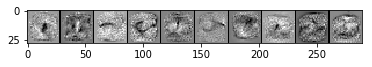

In [28]:
weights = classifier.W.T.eval()

plot_weights(weights, cmap='gray')